# Homework - Logistic Regression implementation with Spark

In this homework you will be implementing logistic regression to classify text documents. The implementation will be in Python, on top of Spark. 

Here are the steps you will follow for this classification task.   
1. Feature standardization  
2. Learning logistic regression model through gradient descent 
3. Evaluating the learned model 

## Data

You will be dealing with a training set that consists of around 170,000 text documents and a test/evaluation
set that consists of around 18,700 text documents. All but around 6,000 of these text documents are Wikipedia
pages; the remaining documents are descriptions of Australian court cases and rulings. At the highest level,
your task is to build a classifier that can automatically figure out whether a text document is an Australian
court case.

We have prepared four datasets for your use. Two of them are the entire training set and test set that are counted as "big" files and are stored in S3. Two of them are subsets of training set and test set that are counted as "small" files and are stored in the `data` directory of your Vocareum workspace. 

* The entire training set (~ 1.8 GB of text): `s3://comp643bucket/homework/spark_logreg/TrainingDataOneLinePerDoc.txt`
* The entire test set (~ 200 MB of text): `s3://comp643bucket/homework/spark_logreg/TestingDataOneLinePerDoc.txt`
* The small subset of training set : `data/SmallTrainingDataOneLinePerDoc.txt`
* The small subset of test set : `data/SmallTestingDataOneLinePerDoc.txt`

As before, you should start running and debugging your code on the small datasets through this Jupyter Notebook, and then run your code in AWS EMR cluster on the entire big datasets.  

The training and test sets are text files that every line in the file represents a document. Take a look at the small training set `SmallTrainingDataOneLinePerDoc.txt`. You'll see that each document begins with a `<doc id = ...>` tag, and ends with `</doc>`. The texual body of each document is stored inside the `<doc>` tag. 

Note that all of the Australia legal cases begin with something like `<doc id = "AU..." ...>`;
that is, the doc id for an Australian legal case always starts with `AU`. Other documents from Wikipedia have a pure numeric doc id. Therefore, doc id indicates the "label" or "class" of each document; i.e., whether it's an Australian court case or not.

You will be learning your logistic regression model based on this "labeled" training set. Then, the goal is to have a model that can predict if the document is an Australian legal case by **only** looking at the contents of the document. 

In [1]:
import pyspark
import re
import numpy as np

In [2]:
# pyspark works best with java8 
# set JAVA_HOME enviroment variable to java8 path 
%env JAVA_HOME = /usr/lib/jvm/java-8-openjdk-amd64

env: JAVA_HOME=/usr/lib/jvm/java-8-openjdk-amd64


In [3]:
sc = pyspark.SparkContext()

## Provided code - creating reference dictionary 

This provided code is the same as what you've seen in `Lab - Spark introduction (Vocareum)`, and `Homework - kNN implementation with Spark`. We need a dictionary, as an RDD, that includes the `numWords` (50 for small dataset, 20,000 for big dataset) most frequent words
in the training corpus. The result of such an RDD must be in this format:

`
[('mostcommonword', 0),
 ('nextmostcommonword', 1),
 ...]
`

Run the code cells below to create this dictionary, named `refDict`, as an RDD. This `refDict` RDD will be our reference dictionary of words. The words in `refDict` will be our reference words for which we will compute "TF-IDF" features for our training corpus and finally for the test documents.

In [4]:
# set the number of dictionary words 
# 50 for the small dataset
# 20,000 for the large dataset
numWords = 50

In [5]:
# load up the training dataset 
# "data/SmallTrainingDataOneLinePerDoc.txt" for small dataset 
# "s3://comp643bucket/homework/spark_logreg/TrainingDataOneLinePerDoc.txt" for entire large dataset
corpus = sc.textFile ("data/SmallTrainingDataOneLinePerDoc.txt")

# each entry in validLines will be a line from the text file
corpus_validLines = corpus.filter(lambda x : 'id=' in x)

# now we transform it into a bunch of (docID, text) pairs
keyAndText = corpus_validLines.map(lambda x : (x[x.index('id="') + 4 : x.index('" url=')], x[x.index('">') + 2:x.index(' </doc>')]))

# now we split the text in each (docID, text) pair into a list of words
# after this, we have a dataset with (docID, ["word1", "word2", "word3", ...])
# we have a bit of fancy regular expression stuff here to make sure that we do not
# die on some of the documents                       
regex = re.compile('[^a-zA-Z]')  
keyAndListOfWords = keyAndText.map(lambda x : (str(x[0]), regex.sub(' ', x[1]).lower().split()))

# now get the top numWords words... first change (docID, ["word1", "word2", "word3", ...])
# to ("word1", 1) ("word2", 1)...
allWords = keyAndListOfWords.flatMap(lambda x: ((j, 1) for j in x[1]))

# now, count all of the words, giving us ("word1", 1433), ("word2", 3423423), etc.
allCounts = allWords.reduceByKey (lambda a, b: a + b)

# and get the top numWords frequent words in a local array
topWords = allCounts.top (numWords, lambda x : x[1])

# and we'll create an RDD that has a bunch of (word, rank) pairs
# start by creating an RDD that has the number 0 up to numWords (50 for small dataset, 20K for large dataset) 
# numWords is the number of words that will be in our dictionary
twentyK = sc.parallelize(range(numWords))

# now, we transform (0), (1), (2), ... to ("mostcommonword", 0) ("nextmostcommon", 1), ...
# the number will be the spot in the dictionary used to tell us where the word is located
refDict = twentyK.map(lambda x:(topWords[x][0],x))

In [6]:
refDict.take(10)

[('the', 0),
 ('of', 1),
 ('and', 2),
 ('in', 3),
 ('to', 4),
 ('a', 5),
 ('was', 6),
 ('for', 7),
 ('on', 8),
 ('s', 9)]

## Provided code - TF-IDF feature extraction from the training set

Run the cell below to define the function, `compute_tfidf_training()`, which gets a training set as an RDD and a reference dictionary of words as an RDD, and computes TF-IDF feature vector of each document in the training set. This function returns `tf` as the term frequency, `idf` as the inverse document frequency, and finally `tfidf` ad the TF-IDF feature vector.   

The outputs `tf` and `tfidf` are key-value pair RDDs, while `idf` is a single 1D numpy array. 

In [7]:
def compute_tfidf_training (dataset, dictionary=refDict):
    
    # each entry in validLines will be a line from the text file
    validLines = dataset.filter(lambda x : 'id=' in x)

    # now we transform it into a bunch of (docID, text) pairs
    keyAndText = validLines.map(lambda x : (x[x.index('id="') + 4 : x.index('" url=')], x[x.index('">') + 2:x.index(' </doc>')]))

    # now we split the text in each (docID, text) pair into a list of words
    # after this, we have a dataset with (docID, ["word1", "word2", "word3", ...])
    # we have a bit of fancy regular expression stuff here to make sure that we do not
    # die on some of the documents                       
    regex = re.compile('[^a-zA-Z]')  
    keyAndListOfWords = keyAndText.map(lambda x : (str(x[0]), regex.sub(' ', x[1]).lower().split()))
    
    # compute tf-idf
    
    word_docid_pair = keyAndListOfWords.flatMap(lambda x:((j,x[0]) for j in x[1]))
    joined_rdd = word_docid_pair.join(dictionary)
    docid_wordpos_pair = joined_rdd.map(lambda x: x[1]) # or: joined_rdd.values()
    grouped_docs = docid_wordpos_pair.groupByKey()

    def create_array (lst):
        arr = np.zeros(numWords)
        for word_pos in lst:
            arr[word_pos] += 1
        return arr

    bag_of_words = grouped_docs.map(lambda x: (x[0], create_array(x[1])))

    doc_total_num_words = keyAndListOfWords.mapValues(lambda x: len(x))
    joined_rdd2 = bag_of_words.join(doc_total_num_words)
    tf = joined_rdd2.mapValues(lambda x: x[0]/x[1])

    numerator = validLines.count()
    binary_vector = bag_of_words.mapValues(lambda x: np.clip(x, 0, 1))
    denominator = binary_vector.values().reduce(lambda a, b: a + b)
    idf = np.log(numerator/denominator)

    tfidf = tf.mapValues(lambda x: x*idf)

    return tf, idf, tfidf

Call `compute_tfidf_training()` function on the `corpus`, which is our training set RDD, and save the result TF-IDF RDD as `training_tfidf`.  

In [8]:
training_tfidf = compute_tfidf_training(corpus)[2]

In [9]:
training_tfidf.take(3)

[('19208664',
  array([1.47166563e-05, 1.01799427e-05, 0.00000000e+00, 5.31127447e-06,
         2.49110802e-05, 1.85921622e-05, 4.01957827e-05, 5.98737153e-05,
         1.06706853e-05, 3.23157980e-05, 1.99333791e-03, 2.43787808e-05,
         2.94769073e-04, 2.21916311e-05, 7.08844680e-05, 0.00000000e+00,
         2.89736884e-04, 1.24594741e-04, 0.00000000e+00, 5.04396537e-04,
         2.11156785e-04, 0.00000000e+00, 4.50350349e-04, 2.87090912e-04,
         5.01299280e-03, 1.13206052e-03, 0.00000000e+00, 1.98654532e-03,
         1.13851378e-03, 3.70367934e-05, 4.21143188e-04, 8.08145562e-04,
         2.16816705e-04, 1.44277002e-04, 3.18604140e-04, 7.89153875e-04,
         9.26014333e-05, 0.00000000e+00, 0.00000000e+00, 4.78564490e-04,
         4.27914611e-04, 0.00000000e+00, 2.75689878e-04, 0.00000000e+00,
         1.77063182e-04, 2.70631175e-04, 9.23386215e-04, 1.12885050e-03,
         4.48566883e-04, 1.92173193e-04])),
 ('3589511',
  array([3.02581857e-05, 1.07405010e-05, 0.00000000e+

## Task 1 - Standardization (15 pts)

To get good accuracy, you will need to center and normalize the features. That is, transform the features so that the mean of each feature is zero, and the standard deviation is 1. 

The general method of calculation is to determine the mean and standard deviation of each feature. Then, subtract the mean from each feature, and divide the result by the standard deviation.

$$\frac{x-\hat{x}}{\sigma}$$

Among TF-IDF features, you might find features with zero values for all data points. For example, the word `and`, has TF-IDF value of zero for all the documents. That's because it has zero value of IDF. That means, it appears in all documents in the corpus. For the features with a constant value for all the data points, standardization leads to 0/0 resulting in `nan`. Therefore, we ask you to check if standard deviation for any feature equals 0. If it equals 0, change standard deviation from 0 to 1. Then, standardization leads to 0/1 resulting in 0. 

After standardization, to avoid overflow problems, scale down all the features by multiplying with 0.01. 

For this task, start from `training_tfidf` RDD, and standardize feature vectors, following the steps below: 
* Compute the mean vector of each feature (hint: you can use `.mean()` RDD action)
* Compute the standard deviation vector of each feature (hint: you can use `.stdev()` RDD action)
* If standard deviation for any feature equals 0, change 0 to 1 (to avoid division by zero error)
* Subtract the mean vector from the feature vector of each document, divide the result by the standard deviation vector, and finally multiply that with 0.01

Print out your standardized TF-IDF vector for these documents: `"AU35"` and "`7307261`". You can use `filter` RDD operation.

In [10]:
# Start your code here ...


In [11]:
def helper(feature, _mean, _std):
    for i in range(len(feature[1])):
        if _std[i] != 0:
            feature[1][i] = (feature[1][i]- _mean[i])/_std[i]*.01
        else:
            feature[1][i] = (feature[1][i]- _mean[i])/1*.01
    return feature

def standardize(X):
    n = training_tfidf.count()
    my_rdd = X.map(lambda x: x[1])
    sum_rdd = my_rdd.reduce(lambda x,y: [x[i] + y[i] for i in range(len(x))])
    mean_rdd = my_rdd.mean()
    std_rdd = my_rdd.stdev()
    my_rdd = X.map(lambda x: helper(x, mean_rdd, std_rdd))
    return my_rdd, mean_rdd, std_rdd

rdd_standardized, training_mean, training_std = standardize(training_tfidf)

Print out your standardized TF-IDF vector for document `"AU35"`. You can use `filter` RDD operation.

In [12]:
rdd_standardized.filter(lambda x: x[0] == 'AU35').take(1)

[('AU35',
  array([ 0.01917376,  0.0229538 ,  0.        , -0.00998154,  0.02076827,
         -0.0009592 , -0.00692322, -0.00036191,  0.00757805, -0.01217763,
          0.00369896, -0.00121058,  0.02412022,  0.00291001,  0.01022961,
         -0.00681456, -0.00386919, -0.00307812,  0.00732501, -0.00195224,
          0.0298327 , -0.00557945,  0.0215187 ,  0.00935466,  0.00184407,
         -0.00684162, -0.00094657,  0.00128596,  0.01845562, -0.00690137,
         -0.00792862, -0.0012177 , -0.00834901, -0.00159449, -0.00692948,
         -0.00459222, -0.00064161, -0.00376526, -0.0090571 , -0.0019166 ,
         -0.00475712, -0.00794101,  0.00054356, -0.00340114, -0.0048421 ,
         -0.00045595, -0.00964884, -0.00364068,  0.01635061,  0.00490286]))]

Expected Output:

```
array([ 0.01917376,  0.0229538 ,  0.        , -0.00998154,  0.02076827,
       -0.0009592 , -0.00692322, -0.00036191,  0.00757805, -0.01217763,
        0.00369896, -0.00121058,  0.02412022,  0.00291001,  0.01022961,
       -0.00681456, -0.00386919, -0.00307812,  0.00732501, -0.00195224,
        0.0298327 , -0.00557945,  0.0215187 ,  0.00935466,  0.00184407,
       -0.00684162, -0.00094657,  0.00128596,  0.01845562, -0.00690137,
       -0.00792862, -0.0012177 , -0.00834901, -0.00159449, -0.00692948,
       -0.00459222, -0.00064161, -0.00376526, -0.0090571 , -0.0019166 ,
       -0.00475712, -0.00794101,  0.00054356, -0.00340114, -0.0048421 ,
       -0.00045595, -0.00964884, -0.00364068,  0.01635061,  0.00490286])
  ```

Print out your standardized TF-IDF vector for document `"7307261"`. You can use `filter` RDD operation.

In [13]:
rdd_standardized.filter(lambda x: x[0] == '7307261').take(1)

[('7307261',
  array([-7.98187554e-03,  6.44571046e-03,  0.00000000e+00,  1.20485679e-02,
         -6.81563684e-03,  1.12378330e-02,  1.41503000e-02,  1.09114367e-03,
         -2.26269109e-03, -3.64324981e-03, -7.06642008e-03, -7.82343895e-03,
         -9.55214973e-03,  1.85846808e-03, -2.04826154e-05,  2.20378309e-02,
         -1.33662670e-02,  7.30579304e-03,  3.53757580e-02, -9.82593906e-03,
          7.50789751e-03, -3.48273544e-03, -6.71881312e-03, -4.97827624e-03,
         -1.60208364e-04,  4.36068136e-03, -2.14132084e-03, -6.93201579e-03,
         -8.29401163e-04,  8.37691038e-03, -5.05860163e-03, -9.46833209e-03,
          3.20985306e-03, -1.32371288e-04,  4.90336882e-03, -8.21678465e-03,
         -4.61530147e-03, -3.76526352e-03, -1.06271960e-02, -3.47563951e-03,
          6.81019242e-04,  1.10967848e-02, -1.05304023e-02, -3.40113524e-03,
         -9.92591863e-03, -1.11902424e-02,  1.67329921e-02,  9.56685283e-03,
         -2.66253290e-03, -7.06197714e-03]))]

Expected Output:

```
array([-7.98187554e-03,  6.44571046e-03,  0.00000000e+00,  1.20485679e-02,
       -6.81563684e-03,  1.12378330e-02,  1.41503000e-02,  1.09114367e-03,
       -2.26269109e-03, -3.64324981e-03, -7.06642008e-03, -7.82343895e-03,
       -9.55214973e-03,  1.85846808e-03, -2.04826154e-05,  2.20378309e-02,
       -1.33662670e-02,  7.30579304e-03,  3.53757580e-02, -9.82593906e-03,
        7.50789751e-03, -3.48273544e-03, -6.71881312e-03, -4.97827624e-03,
       -1.60208364e-04,  4.36068136e-03, -2.14132084e-03, -6.93201579e-03,
       -8.29401163e-04,  8.37691038e-03, -5.05860163e-03, -9.46833209e-03,
        3.20985306e-03, -1.32371288e-04,  4.90336882e-03, -8.21678465e-03,
       -4.61530147e-03, -3.76526352e-03, -1.06271960e-02, -3.47563951e-03,
        6.81019242e-04,  1.10967848e-02, -1.05304023e-02, -3.40113524e-03,
       -9.92591863e-03, -1.11902424e-02,  1.67329921e-02,  9.56685283e-03,
       -2.66253290e-03, -7.06197714e-03])
```

## Task 2 - Add intercept (10 pts) 

Without adding intercept to your model (adding an extra feature with a constant value), you will probably see a poor prediction. 

You can greatly improve your model by adding an intercept to your model. You can do that by adding another feature, called intercept, to your standardized training set with a constant value for all the data points. The learning process will then choose a regression coefficient for the intercept that tends to balance the “yes” and “no” nicely at a cutoff of zero.

Generally, the constant value to add is 1. But, since we scaled down the standardized features by multiplying with 0.01, for this task, **add a new feature at the end of the standardized feature vector of all documents with the constant value 0.01.** Apply this change on the standardized RDD you got from task 1.    

Print out your standardized TF-IDF vector with an intercept feature at the end for these documents: `"AU35"` and "`7307261`". You can use `filter` RDD operation. The expected result should be the same as task 1, plus having 0.01 at the end of arrays.  

In [14]:
# Start your code here ...

In [15]:
def add_intercept(X):
    my_rdd = X.map(lambda x: (x[0], np.append(x[1], 0.01)))
    return my_rdd

my_rdd = add_intercept(rdd_standardized)

In [16]:
rdd_standardized.filter(lambda x: x[0] == 'AU35').take(1)

[('AU35',
  array([ 0.01917376,  0.0229538 ,  0.        , -0.00998154,  0.02076827,
         -0.0009592 , -0.00692322, -0.00036191,  0.00757805, -0.01217763,
          0.00369896, -0.00121058,  0.02412022,  0.00291001,  0.01022961,
         -0.00681456, -0.00386919, -0.00307812,  0.00732501, -0.00195224,
          0.0298327 , -0.00557945,  0.0215187 ,  0.00935466,  0.00184407,
         -0.00684162, -0.00094657,  0.00128596,  0.01845562, -0.00690137,
         -0.00792862, -0.0012177 , -0.00834901, -0.00159449, -0.00692948,
         -0.00459222, -0.00064161, -0.00376526, -0.0090571 , -0.0019166 ,
         -0.00475712, -0.00794101,  0.00054356, -0.00340114, -0.0048421 ,
         -0.00045595, -0.00964884, -0.00364068,  0.01635061,  0.00490286]))]

In [17]:
rdd_standardized.filter(lambda x: x[0] == '7307261').take(1)

[('7307261',
  array([-7.98187554e-03,  6.44571046e-03,  0.00000000e+00,  1.20485679e-02,
         -6.81563684e-03,  1.12378330e-02,  1.41503000e-02,  1.09114367e-03,
         -2.26269109e-03, -3.64324981e-03, -7.06642008e-03, -7.82343895e-03,
         -9.55214973e-03,  1.85846808e-03, -2.04826154e-05,  2.20378309e-02,
         -1.33662670e-02,  7.30579304e-03,  3.53757580e-02, -9.82593906e-03,
          7.50789751e-03, -3.48273544e-03, -6.71881312e-03, -4.97827624e-03,
         -1.60208364e-04,  4.36068136e-03, -2.14132084e-03, -6.93201579e-03,
         -8.29401163e-04,  8.37691038e-03, -5.05860163e-03, -9.46833209e-03,
          3.20985306e-03, -1.32371288e-04,  4.90336882e-03, -8.21678465e-03,
         -4.61530147e-03, -3.76526352e-03, -1.06271960e-02, -3.47563951e-03,
          6.81019242e-04,  1.10967848e-02, -1.05304023e-02, -3.40113524e-03,
         -9.92591863e-03, -1.11902424e-02,  1.67329921e-02,  9.56685283e-03,
         -2.66253290e-03, -7.06197714e-03]))]

## Task 3 - Learning logistic regression (40 pts)

For this task, you will be implementing the gradient descent algorithm to learn a logistic regression model that can decide whether a document is describing an Australian court case or not. The algorithm needs to include Bold Driver, and uses loss function for stopping condition (i.e., stop when the change in the loss function across iterations is very small). Also, terminate the iterations if exceeds `numIters` number of iterations.   

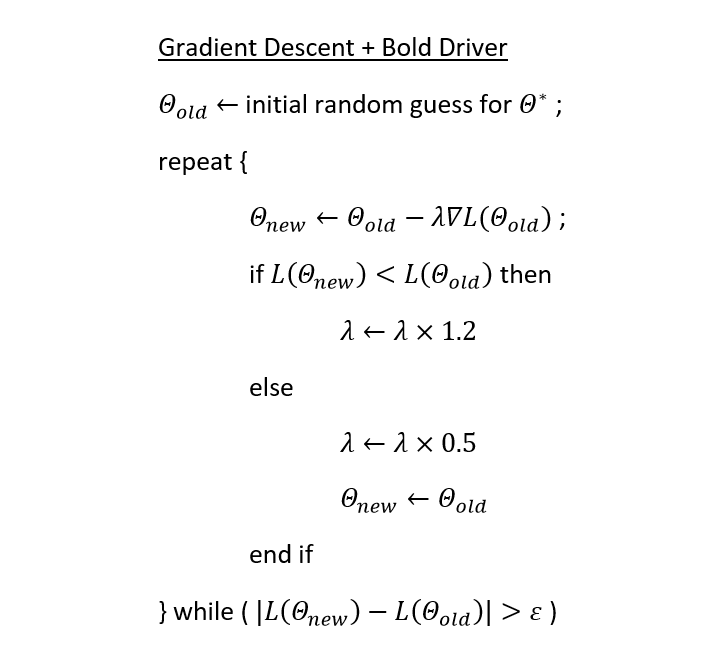

To implement this pseudocode in Python, you can follow the template below:  
```
theta_old = initial random guess
loss_old = L(theta_old)
while True:
    theta_new = theta_old - lambda * grad(L)
    loss_new = L(theta_new)
    if loss_new < loss_old then 
        lambda = lambda * 1.2
    else
        lambda = lambda * 0.5
        theta_new = theta_old
    
    if (|loss_new-loss_old|<=eps) or (number of iterations>numIters):
        break
        
    # set theta_new to theta_old to be used for next iteration
    # set loss_new to loss_old to be used for next iteration 
    theta_old = theta_new
    loss_old = loss_new
    
```

As shown in the lecture, here is the loss function you need to define for your logistic regression as well as the formula for the gradient of this loss function: 

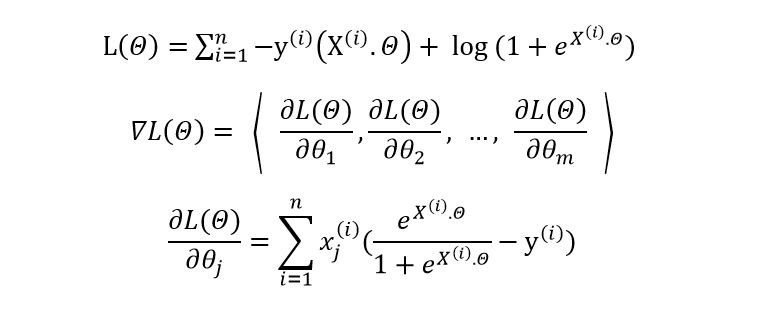

As you can see in the equations, you need to first extract the true labels from the training set, as your $y$ data. The true labels are 1 if the document identifiers start with "AU", and are 0 if not.

$X$ is the feature vector found in the standardized training RDD with the intercept obtained from task 2.  

Some hints for computing the gradient:
* Don't use any loop 
* Try to use Numpy vectorized operations as much as you can (your feature vectors are Numpy arrays) 
* Use `np.exp()`
* $X.\theta$ is the dot product between two vectors of the same length. So, you can use `np.dot()`
* Think about creating this vector of gradient in one shot (don't compute the partial derivative of each parameter separately) 
* You can first focus on the computation per document (inside the summation), create a Numpy array of length m per document that saves the computation inside the summation. Then, finally, summing up the arrays for all documents (e.g., with `.reduce()`) should give you the gradient.  

Finally print out

* the number of iterations actually run
* Numpy array of optimum parameters obtained from Gradient Descent 
* List of (10 words, for the small dataset) / (50 words, for the big dataset) with the largest regression coefficients. These words are most strongly related with an Australian court case.

Expected optimum parameters from the small dataset:
```
[ 7.38323045e+01  2.54714864e+01  6.33648235e-01  3.40237066e+01
  5.48744915e+01 -2.31027718e+01  1.74587806e+01  1.28222075e+01
  1.86123977e+01  4.67262106e+01  1.43255744e+01  1.34234281e+01
  8.56276861e+01 -5.22629427e+00  5.90652961e+01  3.33096411e-01
  7.50921552e+01 -4.04824072e+01  2.37665336e+01 -2.83652222e-01
  2.05283600e+01  5.91440043e+00  4.12990334e+01  4.42113305e+01
 -2.68561194e+01 -2.09157239e+01 -1.68603970e+01  5.18367448e+01
  5.57789301e+01 -3.60130605e+01 -1.43478133e+01  2.29034091e+01
  2.43290077e+00 -5.71928013e+01 -4.71993534e+00  7.29748303e-02
  2.90306629e+01  3.16571750e+01 -3.82349406e+01 -2.84801189e+01
  4.80886851e+00 -2.25162798e+01  8.01842201e+00 -6.24240965e+00
 -2.37859975e+01  4.35101248e+01 -2.92893707e+01 -3.78749285e+01
  2.42452369e+01 -5.22107295e+00 -7.38371195e+02]
```

Run the provided code below to initialize parameters for your gradient descent algorithm.

In [18]:
# provided code
np.random.seed(10)

# initial parameters (+1 for intercept)
theta_init = np.random.random_sample(numWords+1)

lRate = 0.3
eps = 0.1
numIters = 100

In [19]:
# Start your code here ...
my_rdd3 = my_rdd.map(lambda x: ((x[0], x[1], 1) if x[0][:2] == 'AU' 
                                else (x[0], x[1], 0)))

#loss_old = my_rdd3.map(lambda x: -x[2] * np.dot(x[1], theta_init) + np.log(1+np.exp(np.dot(x[1], theta_init)))).reduce(lambda x, y: x+y)
#grad = my_rdd3.map(lambda x: [x[1][i] * np.exp(np.dot(x[1], theta_init))/(1+np.exp(np.dot(x[1], theta_init))) - x[2] for i in range(len(x[1]))])reduce(lambda x, y: np.add(x, y))reduce(lambda x, y: np.add(x, y))
#grad2 = my_rdd3.map(lambda x: x[1]*grad)
#grad2.take(1)
#grad = grad.reduce(lambda x, y: np.add(x, y))
#grad
test = my_rdd3.map(lambda x: x[1] * ((np.exp(np.dot(x[1], theta_init))/(1+np.exp(np.dot(x[1], theta_init)))) - x[2])).reduce(lambda x, y: x + y)
test

array([-6.87464013e-01, -6.01223452e-01,  0.00000000e+00,  1.95409439e-01,
       -1.10801564e+00,  2.81617605e-01,  1.39946276e-01, -2.35082993e-01,
        3.79871245e-02, -1.69986765e-01, -2.97254936e-01,  2.62481246e-01,
       -1.97271280e+00,  6.03488131e-01, -3.27808702e-01,  2.91702013e-01,
        5.77442472e-02,  4.19529505e-01,  2.22507375e-01, -5.90895954e-01,
       -5.20763803e-01,  1.39315733e-01, -1.40394410e+00, -7.87542952e-01,
        7.94858514e-02, -2.83657604e-01, -5.87391892e-02, -9.51398792e-01,
       -2.00028295e+00,  3.73568975e-01,  4.11430566e-01, -1.26717822e-01,
        2.61642511e-01,  3.83395715e-01,  4.28132809e-01,  2.36410453e-01,
       -6.85762173e-01,  1.63091350e-01,  5.89121123e-01,  3.73546657e-01,
       -6.28772943e-02,  3.94590921e-01, -4.02551511e-01,  1.41760198e-01,
        4.91124438e-01, -1.87415296e-01,  3.74667855e-01,  2.44935291e-01,
        7.00157596e-03, -6.81445728e-01,  1.65038098e+01])

In [28]:
def loss(rdd, theta):
    return rdd.map(lambda x: -x[2] * np.dot(x[1], theta) + np.log(1+np.exp(np.dot(x[1], theta)))).reduce(lambda x, y: x+y)

def gradient(rdd, theta):
    return rdd.map(lambda x: x[1] * ((np.exp(np.dot(x[1], theta))/(1+np.exp(np.dot(x[1], theta)))) - x[2])).reduce(lambda x, y: np.add(x, y))

def lr_gd_bd(X, theta_init=theta_init, numIters=numIters, eps=eps, lRate=lRate):
    X.cache()
    i = 0
    theta_old = theta_init
    loss_old = loss(X, theta_old)
    while True:
        theta_new = theta_old - lRate * gradient(X, theta_old)
        loss_new = loss(X, theta_new)
        if loss_new <= loss_old: 
            lRate = lRate * 1.2
        else:
            lRate = lRate * 0.5
            theta_new = theta_old

        if abs(loss_new-loss_old) <= eps or (i > numIters):
            break
        i += 1
 
        theta_old = theta_new
        loss_old = loss_new
    top10_idx = np.argpartition(theta_old[:-1], -10)[-10:]
    top10_words = []
    for i in top10_idx:
        top10_words.append(topWords[i][0])
    
    return i, theta_old, top10_words
        

In [29]:
i, theta_pred, top_words = lr_gd_bd(my_rdd3)
print(i, theta_pred, top_words)

16 [ 7.38323046e+01  2.54714864e+01  6.33648235e-01  3.40237066e+01
  5.48744915e+01 -2.31027718e+01  1.74587806e+01  1.28222075e+01
  1.86123977e+01  4.67262106e+01  1.43255744e+01  1.34234281e+01
  8.56276861e+01 -5.22629426e+00  5.90652962e+01  3.33096388e-01
  7.50921553e+01 -4.04824072e+01  2.37665337e+01 -2.83652234e-01
  2.05283600e+01  5.91440047e+00  4.12990334e+01  4.42113305e+01
 -2.68561195e+01 -2.09157239e+01 -1.68603970e+01  5.18367448e+01
  5.57789301e+01 -3.60130606e+01 -1.43478133e+01  2.29034092e+01
  2.43290079e+00 -5.71928013e+01 -4.71993535e+00  7.29748451e-02
  2.90306629e+01  3.16571751e+01 -3.82349406e+01 -2.84801189e+01
  4.80886852e+00 -2.25162798e+01  8.01842201e+00 -6.24240967e+00
 -2.37859975e+01  4.35101248e+01 -2.92893707e+01 -3.78749285e+01
  2.42452369e+01 -5.22107298e+00 -7.38371195e+02] ['other', 'which', 's', 'by', 'to', 'not', 'or', 'the', 'that', 'at']


## Task 3 - prediction (35 pts)

Now that you have trained your model and found the optimum parameters, it is time to evaluate it. 

For the last part of this homework, your task is to apply your model on the provided test set, and get the predictions. Use the cutoff $ X.\theta = 0$ 

If $ X.\theta > 0$ , classify as 1 (Australian court case)  
If $ X.\theta <= 0$ , classify as 0 (Not an Australian court case)  

To extract and prepare the feature vectors of the test set, 
* use the provided function `compute_tfidf_test` below.
* then, similar to task1, standardize the feature vectors of the test set. **Just note to use the same mean and std from the training set.** 
* then, similar to task 2, add an extra feature at the end of the feature vector with the constant value 0.01 for all the test documents.   

To evaluate the performance of your model, compute the F1 score based on the predicted classes and the actual classes found in the test document identifiers.   

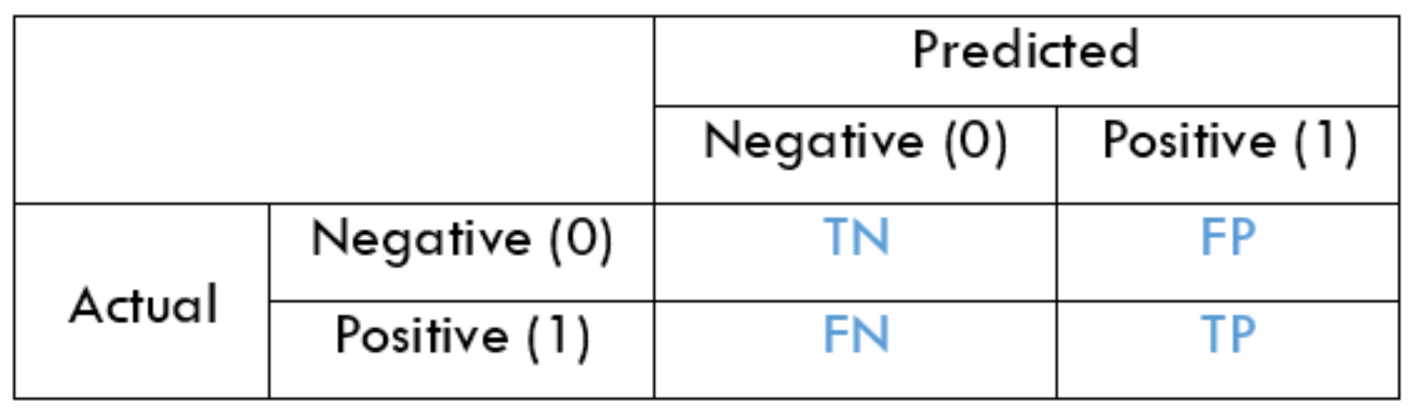


$precision = \frac{TP}{TP+FP}$

$recall = \frac{TP}{TP+FN}$

$F1-score = \frac{2*precision*recall}{precision+recall}$

Finally print out the evaluation results: precision, recall, and F1-score. 

### Provided code - TF-IDF feature extraction from test set

Run the code cells below to define a function that computes TF-IDF feature vector of every document in the test set, and call this function on the provided test set. 

In [22]:
def compute_tfidf_test (dataset, dictionary=refDict):
    
    # each entry in validLines will be a line from the text file
    validLines = dataset.filter(lambda x : 'id=' in x)

    # now we transform it into a bunch of (docID, text) pairs
    keyAndText = validLines.map(lambda x : (x[x.index('id="') + 4 : x.index('" url=')], x[x.index('">') + 2:x.index(' </doc>')]))

    # now we split the text in each (docID, text) pair into a list of words
    # after this, we have a dataset with (docID, ["word1", "word2", "word3", ...])
    # we have a bit of fancy regular expression stuff here to make sure that we do not
    # die on some of the documents                       
    regex = re.compile('[^a-zA-Z]')  
    keyAndListOfWords = keyAndText.map(lambda x : (str(x[0]), regex.sub(' ', x[1]).lower().split()))
    
    # compute tf-idf
    
    word_docid_pair = keyAndListOfWords.flatMap(lambda x:((j,x[0]) for j in x[1]))
    joined_rdd = word_docid_pair.join(dictionary)
    docid_wordpos_pair = joined_rdd.map(lambda x: x[1]) # or: joined_rdd.values()
    grouped_docs = docid_wordpos_pair.groupByKey()

    def create_array (lst):
        arr = np.zeros(numWords)
        for word_pos in lst:
            arr[word_pos] += 1
        return arr

    bag_of_words = grouped_docs.map(lambda x: (x[0], create_array(x[1])))

    doc_total_num_words = keyAndListOfWords.mapValues(lambda x: len(x))
    joined_rdd2 = bag_of_words.join(doc_total_num_words)
    tf = joined_rdd2.mapValues(lambda x: x[0]/x[1])

    idf = compute_tfidf_training(corpus)[1]

    tfidf = tf.mapValues(lambda x: x*idf)

    return tf, idf, tfidf

In [23]:
# load up the test dataset 
# "data/SmallTestingDataOneLinePerDoc.txt" for small dataset 
# "s3://comp643bucket/homework/spark_logreg/TestingDataOneLinePerDoc.txt" for entire large dataset
test = sc.textFile ("data/SmallTestingDataOneLinePerDoc.txt")
test_tfidf = compute_tfidf_test(test)[2]


In [24]:
# Start your code here ...

In [25]:
#Standardize using training mean and std
n = test_tfidf.count()
#test_rdd = test_tfidf.map(lambda x: x[1])
test_rdd = test_tfidf.map(lambda x: helper(x, training_mean, training_std))


In [26]:
#add y=intercept
test_rdd = add_intercept(test_rdd)
test_rdd.take(2)

[('355337',
  array([ 1.55841647e-03,  6.83179782e-05,  0.00000000e+00, -2.28751895e-03,
          3.56378249e-03, -6.89762111e-03,  2.12643278e-03,  1.94730712e-03,
          1.30862359e-03,  1.06980819e-02,  2.37522507e-03, -7.63669445e-03,
          1.80319403e-04,  4.50944691e-03,  2.20120506e-03,  1.73841088e-03,
          5.35893328e-03, -8.51936614e-04,  1.02140228e-02,  6.24500666e-03,
          2.93110282e-03, -4.57577471e-03, -3.46694753e-03,  1.77834144e-03,
         -1.90162713e-03, -6.40499819e-04,  6.59633165e-03, -5.82337434e-03,
          4.47778401e-03, -4.73209253e-03, -1.22126865e-03,  7.20769766e-05,
          2.06113674e-03,  1.03530626e-02,  7.73748621e-03,  3.19251994e-03,
         -1.58563554e-03,  2.07496817e-02,  4.19974807e-03, -4.24445099e-03,
         -3.30321505e-03,  1.05881312e-02,  4.40887571e-03,  8.32219467e-03,
         -5.35372179e-03, -2.50161903e-03,  6.42327531e-04, -6.59729069e-03,
         -6.46688325e-03, -4.75610577e-03,  1.00000000e-02])),
 

In [27]:
def predict(rdd, theta):
    true = rdd.map(lambda x: ((x[0], 1) if x[0][:2] == 'AU' 
                                else (x[0], 0)))
    pred = rdd.map(lambda x: ((x[0], 1 if np.dot(x[1], theta) > 0
                                else 0)))
    combined = true.join(pred)
    tp = combined.filter(lambda x: x[1][0] == 1 and x[1][1] == 1).count()
    fp = combined.filter(lambda x: x[1][0] == 0 and x[1][1] == 1).count()
    fn = combined.filter(lambda x: x[1][0] == 1 and x[1][1] == 0).count()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*precision*recall/(precision+recall)
    return precision, recall, f1
predict(test_rdd, theta_pred)


(0.8409090909090909, 0.925, 0.8809523809523809)

## Task 5 - run on the entire dataset in EMR cluster (5 pts)

Finally, you need to run your Spark code for tasks 1 through 4, on the entire dataset stored in S3, in an AWS EMR cluster.

Follow the instructions on `Lab - Spark Intro (AWS)` to create and connect to an EMR cluster in AWS and run Spark programs in there. 

**Choose 3 `m5.2xlarge` machines as workers.** 

You can gather your code for each task in a Python `.py` file and submit them as jobs in the batch mode and get the final result back. To troubleshoot, you can run your code line by line, in an interactive mode to debug your program.     

**Don't forget to set `numWords` to 20,000 and replace datasets directory to S3 locations.**

The entire dataset exists in this S3 URI: 

* The entire training set (~ 1.8 GB of text): `s3://comp643bucket/homework/spark_logreg/TrainingDataOneLinePerDoc.txt`

* The entire test set (~ 200 MB of text): `s3://comp643bucket/homework/spark_logreg/TestingDataOneLinePerDoc.txt`

Our solution runs about 40 minutes on a cluster of 3 `m5.2xlarge` machines. If you find that your training takes more than a few hours to run on the big dataset, it likely means that you are doing something that is inherently slow that you can speed up by looking at your code carefully. In addition, here are some hints that can help your code run faster:
1. You might want to explicitly partition the data to fully make use of your powerful machines, by setting `minPartitions` parameter in `sc.textFile()`. This parameter sets minimum number of partitions for the resulting RDD. As an example, you can set this to 16. 

2. Think about caching RDD(s), through `.cache()` method. Although it is simply a function call of `.cache()`, you need to think about which RDD(s) to cache. It obviously does not make sense to cache everything. You can cache RDDs that are frequently called. 

Repeat tasks 1 through 4 on the entire dataset in your EMR cluster, and print your results in the markdown cells below (keep the results from the small subset above). 

Task 1 - Print out your standardized TF-IDF vector for these documents: `"AU35"` and `"7307261"`. It's fine if the print out you get only shows the first and last 3 entries. Just copy the result here. 

It was too slow on AWS. Could you please point out where I could speed things up?

Task 2 - Print out, the number of iterations actually run, Numpy array of optimum parameters obtained from Gradient Descent, List of 50 words with the largest regression coefficients. These words are most strongly related with an Australian court case. 

...

Task 3 - Print out the evaluation results: precision, recall, and F1-score 

...